In [2]:
# resources
# https://akshaysin.github.io/fourier_transform.html#.XJmGKRNKgdV

In [3]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical

Using TensorFlow backend.


In [4]:
import os, sys
from os.path import dirname, abspath, basename, exists, splitext
from os.path import join as joinPath
import numpy as np
import cv2
from matplotlib import pyplot as plt

from skimage.feature import greycomatrix, greycoprops

In [5]:
import cv2
import datetime as dt
import h5py
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import numpy as np
import os
import pandas as pd
from glob import glob
import shutil

In [170]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3

class Utils:
    """Contains general utility functions to support other classes"""
    def __init__(self,
                 data_dir='/Users/yachnasharma/Downloads/' +
                          'case_study_visual_intelligence/' +
                          'home_depot_products/'):
        self.data_dir = data_dir
#         self.data_dir = os.path.abspath(os.path.join('../home_depot_products/'))
        self.image_height = 256
        self.image_width = 256
        self.image_channels = 3
        self.class_labels = {'bar_stool'      : 0, 
                             'bookcase'       : 1,
                             'chandelier'     : 3,
                             'dining_chair'   : 4,
                             'market_umbrella': 5,
                             'night_stands'   : 6,
                             'ottoman'        : 7,
                             'sconces'        : 8,
                             'table_lamp'     : 9,
                             'vases'          : 10
                            }
        self.glcm_thresh = {'bar_stool'      : 45, 
                            'bookcase'       : 45,
                            'chandelier'     : 45,
                            'dining_chair'   : 45,
                            'market_umbrella': 45,
                            'night_stands'   : 45,
                            'ottoman'        : 45,
                            'sconces'        : 45,
                            'table_lamp'     : 45,
                            'vases'          : 45
                            }


In [ ]:
class ImageFeatures(Utils):
    """Computes discrete fourier transform of an image to capture image frequencies.
       The dft image is used to compute the image texture features using GLCM(gray level co-occurence matrices)
    """
    
    def __init__(self, image):
        """Initializes imagefeatures"""
        self.image = image
        self.glcm_props = {'dissimilarity': [],
                           'correlation': [],
                           'contrast': [],
                           'homogeneity': [],
                           'asm': [],
                           'energy': [],
                           'labels': []
                           }
        super()

    def fft_spectrum(self, input_image):
        """Computes Discrete Fourier Transform(DFT) of the input image"""
#         https://docs.opencv.org/2.4.13.7/doc/tutorials/core/
#        discrete_fourier_transform/discrete_fourier_transform.html

        dft = cv2.dft(np.float32(input_image), flags=cv2.DFT_COMPLEX_OUTPUT)
        dft_shift = np.fft.fftshift(dft)
        magnitude_spectrum = np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))
        return magnitude_spectrum
    
    def get_glcm_features(self, input_image):
        """Computes glcm features for the give input image"""
        image = np.uint8(input_image)
        glcm = greycomatrix(image, [5], list(np.arange(0, 360, 30)), 256, symmetric=True, normed=True)
        dis = greycoprops(glcm, 'dissimilarity')[0][0]
        cor = greycoprops(glcm, 'correlation')[0][0]
        con = greycoprops(glcm, 'contrast')[0][0]
        hom = greycoprops(glcm, 'homogeneity')[0][0]
        asm = greycoprops(glcm, 'ASM')[0][0]
        energy = greycoprops(glcm, 'energy')[0][0]
        return {'dissimilarity': dis,
            'correlation':cor,
            'contrast':con,
            'homogeneity': hom,
            'asm': asm,
            'energy': energy}
    
    def update_results(self, result, glcm_props, label):
        for k,_ in glcm_props.items():
            if k == 'labels':
                glcm_props[k].append(label)
            else:
                glcm_props[k].append(result[k])
        return glcm_props


    def filter_images(self):
        """Reads images for each class and removes images not suitable for training."""
        for cls,_ in self.class_labels.items():
            cls_path = self.data_dir + cls + '/'
            print(cls_path)
            images = glob(os.path.join(cls_path, "*.jpg"))
            for i,img in enumerate(images):
                image_fname = 
                try:
                    image = cv2.imread(img)
                    height, width, channels = image.shape
                    print(height, width)
                    if height < 1000 or width < 1000:
                        label = 0
                    else:
                        label = 1
                    image = cv2.resize(image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC)
                    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    magnitude_spectrum = self.fft_spectrum(gray)
                    result = self.get_glcm_features(magnitude_spectrum)
                    glcm_props = self.update_results(result, glcm_props, label)
                    if result['dissimilatiy'] > self.glcm_thresh[cls]:
                        destination_dir = self.data_dir + cls + '/' + '_filtered_out/'
                        # move the image to filtered folder where images not suitable for training are placed
                        if not os.path.exists(destination_dir):
                            os.makedir(destination_dir)
                        shutil.move(img, destination_dir)
                        
        return glcm_props
            
        

In [ ]:

class DataProcess(Utils, ImageFeatures):
    """Reads, processes and prepares image data."""

    def __init__(self):
        """initializes class_labels and defines GLCM
           dissimilarity thresholds to remove outlier
           images.
        """
        self.data_dir = os.path.abspath(os.path.join('../home_depot_products/'))
        self.duplicate_file_marker = '1'
        super()


    def flatten_subdir(self, current_dir):
    """Move all files in subdirs to here, then delete subdirs.
       Conflicting files are renamed, with 1 appended to their name."""
    
        for root, dirs, files in os.walk(current_dir, topdown=False ):
            if root != here:
                for name in files:
                    source = joinPath(root, name)
                    target = self.handleDuplicates(joinPath(current_dir, name))
                    os.rename(source, target)

            for name in dirs:
                os.rmdir(joinPath(root, name))
            
    def handleDuplicates(self, target):
        while exists(target):
            base, ext = splitext(target)
            target    = base + self.duplicate_file_marker + ext
        return target

    def read_and_process(self):
        """Reads image files from different class directories
           and filters out the outlier images based on GLCM dissimilarity
           threshold for the given class.
        """
        for cls, params in self.class_labels.items():
            flatten_subdir(self.data_dir + cls + '/')
            
            
            
        

In [6]:
import os
os.path.abspath(os.path.join('../home_depot_products/'))

'/Users/yachnasharma/Downloads/case_study_visual_intelligence/VIntel/home_depot_products'

In [18]:

classes = {0:'bar_stool', 1:'bookcase', 2:'chandelier',
           3:'dining_chair', 4:'market_umbrella', 5:'night_stands',
           6:'ottoman', 7:'sconces', 8:'table_lamp', 9:'vases'}
PATH_bar_stools = os.path.abspath(os.path.join('../data/home_depot_products/', 'bar_stool/'))
# PATH_bar_stools = os.path.abspath(os.path.join('../home_depot_products/', 'bookcase/'))
# PATH_bar_stools = os.path.abspath(os.path.join('../home_depot_products/', 'chandelier/'))
# PATH_bar_stools = os.path.abspath(os.path.join('../home_depot_products/', 'dining_chair/'))
# PATH_bar_stools = os.path.abspath(os.path.join('../home_depot_products/', 'market_umbrella/'))
# PATH_bar_stools = os.path.abspath(os.path.join('../home_depot_products/', 'night_stands/'))
# PATH_bar_stools = os.path.abspath(os.path.join('../home_depot_products/', 'ottoman/'))
# PATH_bar_stools = os.path.abspath(os.path.join('../home_depot_products/', 'sconces/'))
# PATH_bar_stools = os.path.abspath(os.path.join('../home_depot_products/', 'table_lamp/'))
# PATH_bar_stools = os.path.abspath(os.path.join('../home_depot_products/', 'vases/'))
print(PATH_bar_stools)

/Users/yachnasharma/Downloads/case_study_visual_intelligence/VIntel/data/home_depot_products/bar_stool


In [19]:
bar_stool_files = []
for dirpath, dirs, files in os.walk(PATH_bar_stools):
    bar_stool_files = bar_stool_files + files

In [20]:
bar_stool_files = [file for file in bar_stool_files if file != '.DS_Store']
print(len(bar_stool_files))

341


In [21]:
DUPLICATE_MARKER = '1'

def flattenFiles( here ):
    '''Move all files in subdirs to here, then delete subdirs.
       Conflicting files are renamed, with 1 appended to their name.'''
    for root, dirs, files in os.walk( here, topdown=False ):
        if root != here:
            for name in files:
                source = joinPath( root, name )
                target = handleDuplicates( joinPath( here, name ) )
                os.rename( source, target )

        for name in dirs:
            os.rmdir( joinPath( root, name ) )
            
def handleDuplicates( target ):
    while exists( target ):
        base, ext = splitext( target )
        target    = base + DUPLICATE_MARKER + ext
    return target

In [22]:
# here = '/Users/yachnasharma/Downloads/case_study_visual_intelligence/home_depot_products/bar_stool/'
# here = '/Users/yachnasharma/Downloads/case_study_visual_intelligence/home_depot_products/bookcase/'
# here = '/Users/yachnasharma/Downloads/case_study_visual_intelligence/home_depot_products/chandelier/'
# here = '/Users/yachnasharma/Downloads/case_study_visual_intelligence/home_depot_products/dining_chair/'
# here = '/Users/yachnasharma/Downloads/case_study_visual_intelligence/home_depot_products/market_umbrella/'
# here = '/Users/yachnasharma/Downloads/case_study_visual_intelligence/home_depot_products/night_stands/'
# here = '/Users/yachnasharma/Downloads/case_study_visual_intelligence/home_depot_products/ottoman/'
# here = '/Users/yachnasharma/Downloads/case_study_visual_intelligence/home_depot_products/sconces/'
# here = '/Users/yachnasharma/Downloads/case_study_visual_intelligence/home_depot_products/table_lamp/'
here = '/Users/yachnasharma/Downloads/case_study_visual_intelligence/home_depot_products/vases/'
flattenFiles( here )

In [23]:


def get_fft_spectrum(img):
#     img = cv2.imread('scenery.jpg', 0)
    dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

#     magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))
    magnitude_spectrum = np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

#     plt.subplot(2, 2, 1), plt.imshow(img, cmap='gray')
#     plt.title('Input Image'), plt.xticks([]), plt.yticks([])
#     plt.subplot(2, 2, 2), plt.imshow(magnitude_spectrum, cmap='gray')
#     plt.title('After FFT'), plt.xticks([]), plt.yticks([])
#     plt.show()
    return magnitude_spectrum
    

In [24]:
import matplotlib.pyplot as plt

from skimage.feature import greycomatrix, greycoprops
from skimage import data

def get_glcm_features(image):
    image = np.uint8(image)
    glcm = greycomatrix(image, [5], list(np.arange(0, 360, 30)), 256, symmetric=True, normed=True)
    dis = greycoprops(glcm, 'dissimilarity')[0][0]
    cor = greycoprops(glcm, 'correlation')[0][0]
    con = greycoprops(glcm, 'contrast')[0][0]
    hom = greycoprops(glcm, 'homogeneity')[0][0]
    asm = greycoprops(glcm, 'ASM')[0][0]
    energy = greycoprops(glcm, 'energy')[0][0]
    return {'dissimilarity': dis,
            'correlation':cor,
            'contrast':con,
            'homogeneity': hom,
            'asm': asm,
            'energy': energy}

In [51]:
# https://www.kaggle.com/crawford/resize-and-save-images-as-hdf5-256x256
import cv2
import datetime as dt
import h5py
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import numpy as np
import os
import pandas as pd
from glob import glob



def update_results(result, glcm_props, label, image_name):
    for k,_ in glcm_props.items():
        if k == 'labels':
            glcm_props[k].append(label)
        elif k =='image_name':
            glcm_props[k].append(image_name)
        else:
            glcm_props[k].append(result[k])
    return glcm_props


def proc_images():
    """
    Saves compressed, resized images as HDF5 datsets
    Returns
        data.h5, where each dataset is an image or class label
        e.g. X23,y23 = image and corresponding class label
    """
    
    glcm_props = {'dissimilarity': [],
            'correlation': [],
            'contrast': [],
            'homogeneity': [],
            'asm': [],
            'energy': [],
            'labels': [],
            'image_name': []
        }
    start = dt.datetime.now()
#     # ../input/
#     PATH = os.path.abspath(os.path.join('..', 'input'))
#     # ../input/sample/images/
#     SOURCE_IMAGES = os.path.join(PATH, "sample", "images")
#     # ../input/sample/images/*.png
    SOURCE_IMAGES = PATH_bar_stools
    images = glob(os.path.join(SOURCE_IMAGES, "*.jpg"))
#     print(images)
    # Load labels
#     labels = pd.read_csv('../input/sample_labels.csv')
       
    
    # Size of data
    NUM_IMAGES = len(bar_stool_files)
    HEIGHT = 256
    WIDTH = 256
    CHANNELS = 3
    SHAPE = (HEIGHT, WIDTH, CHANNELS)
    dissimilarity = []
    correlation = []
    labels = []
    with h5py.File('data.h5', 'w') as hf: 
        for i,img in enumerate(images):
#             print(img)
#             print(img.split('/')[-1])
            # Images
            try:
                image = cv2.imread(img)
                height, width, channels = image.shape
                print(height, width)
                if height < 1000 or width < 1000:
                    label = 0
                else:
                    label = 1

                image = cv2.resize(image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC)
                image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                magnitude_spectrum = get_fft_spectrum(gray)
#                 magnitude_spectrum = fft_hpf_filtered(gray)

    
    #                 magnitude_spectrum = fft_bpf_filter(gray)
#             descs = daisy_descriptors(gray)
#             
                result = get_glcm_features(magnitude_spectrum)
#                 if result['dissimilarity'] > 0.027506: # for bar_stool
#                 if result['dissimilarity'] > 45: # for bookcase
#                 if result['dissimilarity'] > 15: # for ottoman
#                 if result['dissimilarity'] > 10: # for ottoman
#                     plb.imshow(image)
#                     plb.show()
                image_name = img.split('/')[-1]
                glcm_props = update_results(result, glcm_props, label, image_name)
                Xset = hf.create_dataset(
                    name='X'+str(i),
                    data=image,
                    shape=(HEIGHT, WIDTH, CHANNELS),
                    maxshape=(HEIGHT, WIDTH, CHANNELS),
                    compression="gzip",
                    compression_opts=9)
                # Labels
                base = os.path.basename(img)
#             finding = labels["Finding Labels"][labels["Image Index"] == base].values[0]
                yset = hf.create_dataset(
                    name='y'+str(i),
                    shape=(1,),
                    maxshape=(None,),
                    compression="gzip",
                    compression_opts=9)
    #YS
                yset = 0
#             if disease in finding:
#                 finding = 1
#                 yset = finding
#             else:
#                 finding = 0
#                 yset = finding
                end=dt.datetime.now()
                print("\r", i, ": ", (end-start).seconds, "seconds", end="")
            except:
                print("Could not open image:" + img)

        return glcm_props

In [52]:
glcm_props = proc_images()

1000 1000
 0 :  0 seconds1000 1000
 1 :  0 seconds1000 1000
 2 :  0 seconds65 65
 3 :  0 seconds65 65
 4 :  0 seconds1000 1000
 5 :  0 seconds1000 1000
 6 :  0 seconds1000 1000
 7 :  0 seconds1000 1000
 8 :  0 seconds1000 1000
 9 :  1 seconds1000 1000
 10 :  1 seconds1000 1000
 11 :  1 seconds1000 1000
 12 :  1 seconds1000 1000
 13 :  1 seconds1000 1000
 14 :  1 seconds1000 1000
 15 :  1 seconds1000 1000
 16 :  1 seconds1000 1000
 17 :  1 seconds65 65
 18 :  2 seconds65 65
 19 :  2 seconds1000 1000
 20 :  2 seconds65 65
 21 :  2 seconds1000 1000
 22 :  2 seconds1000 1000
 23 :  2 seconds65 65
 24 :  2 seconds1000 1000
 25 :  2 seconds1000 1000
 26 :  2 seconds1000 1000
 27 :  2 seconds1000 1000
 28 :  3 seconds1000 1000
 29 :  3 seconds1000 1000
 30 :  3 seconds1000 1000
 31 :  3 seconds1000 1000
 32 :  3 seconds1000 1000
 33 :  3 seconds1000 1000
 34 :  3 seconds1000 1000
 35 :  3 seconds1000 1000
 36 :  3 seconds1000 1000
 37 :  4 seconds1000 1000
 38 :  4 seconds1000 1000
 39 :  4 s

 309 :  33 seconds1000 1000
 310 :  33 seconds1000 1000
 311 :  33 seconds1000 1000
 312 :  33 seconds1000 1000
 313 :  33 seconds1000 1000
 314 :  34 seconds1000 1000
 315 :  34 seconds1000 1000
 316 :  34 seconds1000 1000
 317 :  34 seconds1000 1000
 318 :  34 seconds65 65
 319 :  34 seconds1000 1000
 320 :  34 seconds1000 1000
 321 :  34 seconds1000 1000
 322 :  34 seconds1000 1000
 323 :  35 seconds1000 1000
 324 :  35 seconds1000 1000
 325 :  35 seconds1000 1000
 326 :  35 seconds1000 1000
 327 :  35 seconds1000 1000
 328 :  35 seconds1000 1000
 329 :  35 seconds1000 1000
 330 :  35 seconds1000 1000
 331 :  36 seconds1000 1000
 332 :  36 seconds1000 1000
 333 :  36 seconds65 65
 334 :  36 seconds1000 1000
 335 :  36 seconds1000 1000
 336 :  36 seconds1000 1000
 337 :  36 seconds1000 1000
 338 :  36 seconds1000 1000
 339 :  36 seconds1000 1000
 340 :  36 seconds

In [56]:
df = pd.DataFrame(glcm_props)
df.sample(5)

,dissimilarity,correlation,contrast,homogeneity,asm,energy,labels,image_name
241,1.035530,0.002352,94.798229,0.690169,0.136064,0.368869,1,961e6c15-ab49-4961-b9d6-cba2299e1ea0.jpg
108,1.072616,0.003929,100.774745,0.683455,0.114894,0.338960,1,f8889145-9158-4b1b-81f8-991e9625641c.jpg
246,63.375965,0.394224,16089.107009,0.645954,0.183938,0.428880,0,f10c66cd-675e-4c93-8a45-21cdc80130e4.jpg
69,3.487877,-0.001581,743.184808,0.715688,0.160577,0.400720,1,5f4ce23c-f613-4a40-8fc9-3a159f0b6414.jpg
296,3.170474,-0.002243,652.293794,0.701984,0.099390,0.315262,1,b34e6c9d-5241-4db7-9e05-495038fa38f6.jpg


In [54]:
from sklearn import preprocessing
numeric_cols
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df1 = pd.DataFrame(x_scaled, columns=df.columns)
df1["labels"] = df["labels"]

ValueError: could not convert string to float: '72ecccc0-ed95-46c8-9277-8608a5ce1282.jpg'

In [55]:
df1.describe()

,dissimilarity,correlation,contrast,homogeneity,asm,energy,labels
count,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000
mean,0.212879,0.221659,0.213470,0.236054,0.233503,0.283434,0.809384
std,0.383751,0.379108,0.383503,0.151586,0.167085,0.182246,0.393364
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.009877,0.023787,0.010135,0.179663,0.110075,0.146883,1.000000
50%,0.024859,0.038904,0.025683,0.245676,0.186181,0.239716,1.000000
75%,0.073336,0.079257,0.074633,0.321693,0.291082,0.358649,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
# %matplotlib inline  
# %matplotlib notebook
# %pylab 
# import pandas as pd
# import numpy as np
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D


# # What follows is a copy of the 3D plot example code.
# # Data is randomly generated so there is no external data import.

# # def randrange(n, vmin, vmax):
# #     return (vmax-vmin)*np.random.rand(n) + vmin

# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')
# # n = 100
# # for c, m, zl, zh in [('r', 'o', -60, -25), ('b', '^', -30, -5)]:
# #     xs = randrange(n, 23, 50)
# #     ys = randrange(n, 0, 100)
# #     zs = randrange(n, zl, zh)
# #     ax.scatter(xs, ys, zs, c=c, marker=m)
# ax.scatter(df1['correlation'], df1['homogeneity'], df1['energy'])

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')
# ax.mouse_init()
# plt.show()


In [38]:
df2 = df1.drop(['labels'], axis=1)

In [39]:
# from sklearn.cluster import KMeans
# %matplotlib inline  
# %matplotlib notebook
# %pylab 
# kmeans = KMeans(n_clusters=5)
# kmeans.fit(df2[['correlation', 'homogeneity', 'energy']])

# labels = kmeans.predict(df2[['correlation', 'homogeneity', 'energy']])
# centroids = kmeans.cluster_centers_

# fig = plt.figure(figsize=(6, 6))
# ax = fig.add_subplot(111, projection='3d')

# colors = map(lambda x: colmap[x+1], labels)

# # plt.scatter(df2['correlation'], df2['homogeneity'], color=colors, alpha=0.5, edgecolor='k')
# ax.scatter(df2['dissimilarity'], df2['energy'], df2['homogeneity'], c=kmeans.labels_, edgecolor='k')
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')
# ax.mouse_init()
# plt.show()
# # for idx, centroid in enumerate(centroids):
# #     plt.scatter(*centroid, color=colmap[idx+1])
# # plt.xlim(0, 80)
# # plt.ylim(0, 80)
# # plt.show()

In [40]:
df1.groupby("labels").mean()

,dissimilarity,correlation,contrast,homogeneity,asm,energy
labels,,,,,,
0,1.000000,1.000000,1.000000,0.000000,0.510829,0.582276
1,0.027506,0.038354,0.028237,0.291647,0.168190,0.213054


In [41]:
df['labels'].value_counts()

1    276
0     65
Name: labels, dtype: int64

<IPython.core.display.Javascript object>


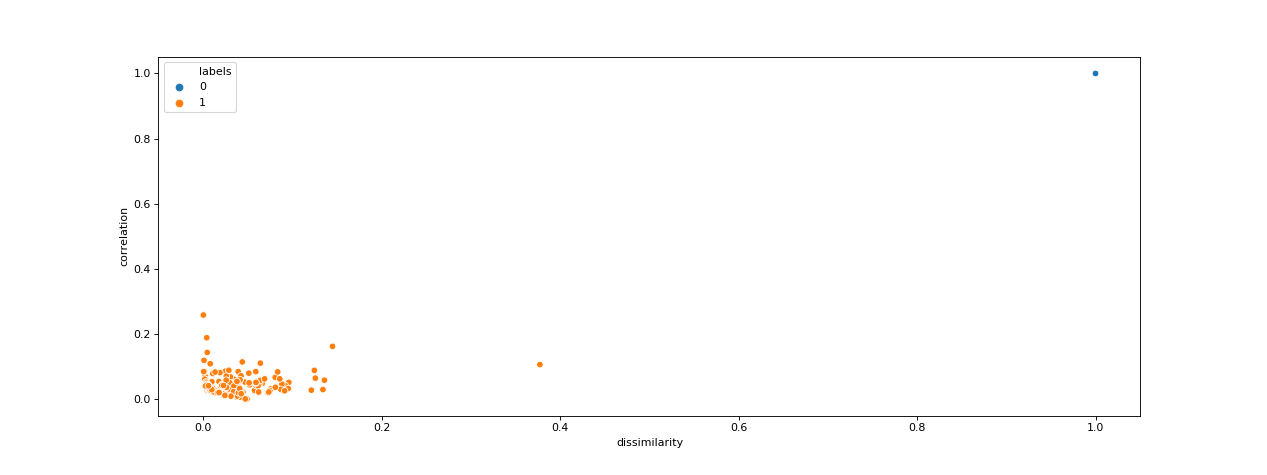

In [43]:
import seaborn as sns
plt.figure(figsize=(16, 6))
sns.scatterplot(x="dissimilarity", y="correlation", hue="labels", data=df1)

<IPython.core.display.Javascript object>


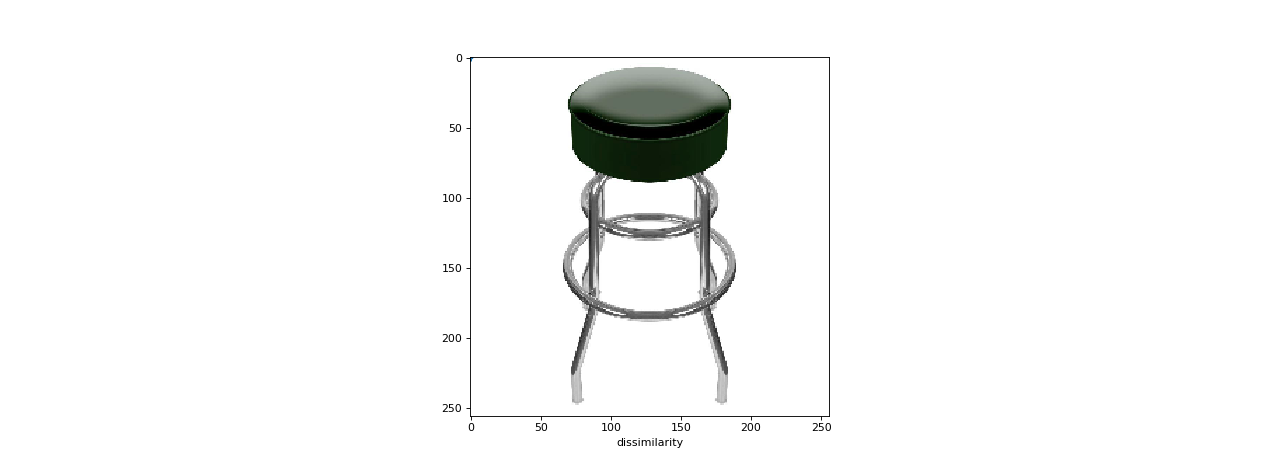

In [44]:
plt.figure(figsize=(16, 6))
sns.distplot(df1['dissimilarity'],kde = True)
plt.show()

<IPython.core.display.Javascript object>


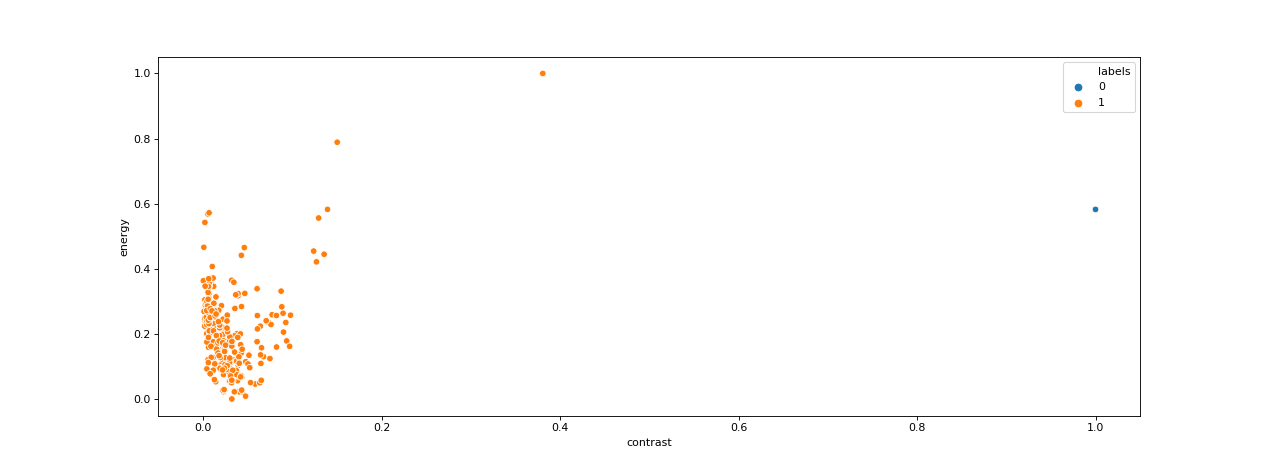

In [33]:
plt.figure(figsize=(16, 6))
sns.scatterplot(x="contrast", y="energy", hue="labels", data=df1)

In [34]:
dat = {'image_names':['a.jpg', 'b.jpg', 'c.jpg'], 'labels': ['lamp', 'table', 'chair']}
df_test = pd.DataFrame(dat)
df_test = pd.concat([df_test, pd.get_dummies(df_test['labels'])], axis=1)
df_test

,image_names,labels,chair,lamp,table
0,a.jpg,lamp,0,1,0
1,b.jpg,table,0,0,1
2,c.jpg,chair,1,0,0


In [104]:
list(np.arange(0, 360, 30))

[0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]

[0.]


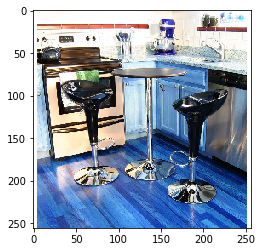

In [43]:
with h5py.File('data.h5', 'r') as hf:
    plb.imshow(hf[("X59")])
    print(hf[("y59")].value)

In [85]:
train_dataset = h5py.File('data.h5', "r")
train_set_x_orig = np.array(train_dataset[("X1")][:]) # your train set features
train_set_y_orig = np.array(train_dataset["y1"][:]) # your train set labels
train_set_y_orig.shape

In [87]:
np.array(train_dataset)

array(['X0', 'X1', 'X10', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105',
       'X106', 'X107', 'X108', 'X109', 'X11', 'X110', 'X111', 'X112',
       'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X12',
       'X120', 'X121', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127',
       'X128', 'X129', 'X13', 'X130', 'X131', 'X132', 'X133', 'X134',
       'X135', 'X136', 'X137', 'X138', 'X139', 'X14', 'X140', 'X141',
       'X142', 'X143', 'X144', 'X145', 'X146', 'X147', 'X148', 'X149',
       'X15', 'X150', 'X151', 'X152', 'X153', 'X154', 'X155', 'X156',
       'X157', 'X158', 'X159', 'X16', 'X160', 'X161', 'X162', 'X163',
       'X164', 'X165', 'X166', 'X167', 'X168', 'X169', 'X17', 'X170',
       'X171', 'X172', 'X173', 'X174', 'X175', 'X176', 'X177', 'X178',
       'X179', 'X18', 'X180', 'X181', 'X182', 'X183', 'X184', 'X185',
       'X186', 'X187', 'X188', 'X189', 'X19', 'X190', 'X191', 'X192',
       'X193', 'X194', 'X195', 'X196', 'X197', 'X198', 'X199', 'X2',
       'X20', 

In [103]:
# https://github.com/manoharan-lab/camera-controller/issues/13
import h5py
import glob
import os.path
import time
# import holopy as hp
import tempfile
from glob import glob as glb

SOURCE_IMAGES = PATH_bar_stools
images = glb(os.path.join(SOURCE_IMAGES, "*.jpg"))

# Size of data
NUM_IMAGES = len(bar_stool_files)
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
SHAPE = (HEIGHT, WIDTH, CHANNELS)
# ims = [hp.load(f) for f in glob.glob('/group/manoharan2/tom/data/2014-09-22/10/*.tif')]
# ims = [hp.load(f) for f in glob.glob('/Users/yachnasharma/Downloads/case_study_visual_intelligence/home_depot_products/bar_stool/*.jpg')]

def setup_hdf5_file(shape, name, **options):
    f = h5py.File(name+'.hdf5', 'w')
    f.create_dataset('data', shape, **options)
    return f

def save_images(f, images):
    for i, im in enumerate(images):
        image = cv2.imread(im)
        image = cv2.resize(image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC)
        f['data'][..., i] = image
    f.close()

def benchmark(name, images, **options):
    tstart = time.time()
    f = setup_hdf5_file((256, 256, 3, NUM_IMAGES), name, **options)
    save_images(f, images)
    tstop = time.time()
    size = os.path.getsize(name+'.hdf5')
    print("{0}: {1:.1f}s, {2}MB".format(name, tstop-tstart, size//1e6))

# benchmark('raw', images)
benchmark('gzipped', images, compression='gzip')
benchmark('tlines', images, compression='gzip', chunks=(1, 1, 3, NUM_IMAGES))
benchmark('tlines_x16', images,compression='gzip', chunks=(16, 16, 3, NUM_IMAGES))
benchmark('tlines_x64', images,compression='gzip', chunks=(64, 64, 3, NUM_IMAGES))

gzipped: 232.5s, 60.0MB


OSError: Unable to create file (unable to truncate a file which is already open)

In [ ]:
def proc_images():
    """
    Saves compressed, resized images as HDF5 datsets
    Returns
        data.h5, where each dataset is an image or class label
        e.g. X23,y23 = image and corresponding class label
    """
    start = dt.datetime.now()
    # ../input/
    PATH = os.path.abspath(os.path.join('..', 'input'))
    # ../input/sample/images/
    SOURCE_IMAGES = os.path.join(PATH, "sample", "images")
    # ../input/sample/images/*.png
    images = glob(os.path.join(SOURCE_IMAGES, "*.png"))
    # Load labels
    labels = pd.read_csv('../input/sample_labels.csv')
       
    # Set the disease type you want to look for
    disease="Infiltration"
    
    # Size of data
    NUM_IMAGES = len(images)
    HEIGHT = 256
    WIDTH = 256
    CHANNELS = 3
    SHAPE = (HEIGHT, WIDTH, CHANNELS)
    
    with h5py.File('data.h5', 'w') as hf: 
        for i,img in enumerate(images):            
            # Images
            image = cv2.imread(img)
            image = cv2.resize(image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC)
            Xset = hf.create_dataset(
                name='X'+str(i),
                data=image,
                shape=(HEIGHT, WIDTH, CHANNELS),
                maxshape=(HEIGHT, WIDTH, CHANNELS),
                compression="gzip",
                compression_opts=9)
            # Labels
            base = os.path.basename(img)
            finding = labels["Finding Labels"][labels["Image Index"] == base].values[0]
            yset = hf.create_dataset(
                name='y'+str(i),
                shape=(1,),
                maxshape=(None,),
                compression="gzip",
                compression_opts=9)
            if disease in finding:
                finding = 1
                yset = finding
            else:
                finding = 0
                yset = finding
            end=dt.datetime.now()
            print("\r", i, ": ", (end-start).seconds, "seconds", end="")